<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/docs/img/football/embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 378.8MB 46kB/s 
     |████████████████████████████████| 4.1MB 42.8MB/s 
     |████████████████████████████████| 450kB 44.4MB/s 
     |████████████████████████████████| 61kB 18.7MB/s 


In [271]:
import tensorflow as tf
print(tf.__version__)

2.0.0-dev20190728


In [292]:
!curl https://raw.githubusercontent.com/DJCordhose/ai/master//docs/img/football/playerData.json -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29407  100 29407    0     0   101k      0 --:--:-- --:--:-- --:--:--  101k


In [0]:
import pandas as pd

In [0]:
df = pd.read_json('playerData.json')

In [295]:
df.head()

,Assists,BallControlPhases,CardsRed,CardsYellow,CardsYellowRed,CrossesNotSuccessfulSum,CrossesSuccessfulSum,CrossesSum,FoulsAgainstOpponent,FreeKicksSum,GoalContribution,Height,MatchMinutes,Name,OwnGoals,PassesNotSuccessfulSum,PassesSuccessfulSum,PassesSum,PenaltiesNotSuccessful,PenaltiesSuccessful,Position,ShotsAtGoalSuccessfull,ShotsAtGoalSum,SubstitutionsIn,SubstitutionsOut,TacklingGamesAirLost,TacklingGamesAirSum,TacklingGamesAirWon,TacklingGamesGroundLost,TacklingGamesGroundSum,TacklingGamesGroundWon,TacklingGamesLost,TacklingGamesSum,TacklingGamesWon,Weight
0,7,1149,0,4,0,6,3,9,35,0,24,197,2931,Wout Weghorst,0,187,464,651,0,4,offense,17,68,1,7,124,255,131,278,555,277,402,810,408,84
1,7,1137,0,2,0,8,2,10,23,10,29,184,2959,Robert Lewandowski,0,136,538,674,0,3,offense,22,141,0,2,89,147,58,257,508,251,346,655,309,80
2,0,398,0,0,0,3,0,3,4,12,18,175,1203,Francisco Alcacer Garcia,0,59,172,231,0,1,offense,18,52,15,8,37,49,12,72,132,60,109,181,72,72
3,4,1382,0,2,0,32,10,42,6,23,21,177,2403,Andrej Kramaric,0,159,747,906,0,5,offense,17,107,2,10,23,31,8,172,315,143,195,346,151,73
4,8,1407,1,3,0,16,3,19,31,26,25,180,2322,Marco Reus,0,155,805,960,0,3,offense,17,70,0,5,42,60,18,280,496,216,322,556,234,71


In [296]:
df.describe()

,Assists,BallControlPhases,CardsRed,CardsYellow,CardsYellowRed,CrossesNotSuccessfulSum,CrossesSuccessfulSum,CrossesSum,FoulsAgainstOpponent,FreeKicksSum,GoalContribution,Height,MatchMinutes,OwnGoals,PassesNotSuccessfulSum,PassesSuccessfulSum,PassesSum,PenaltiesNotSuccessful,PenaltiesSuccessful,ShotsAtGoalSuccessfull,ShotsAtGoalSum,SubstitutionsIn,SubstitutionsOut,TacklingGamesAirLost,TacklingGamesAirSum,TacklingGamesAirWon,TacklingGamesGroundLost,TacklingGamesGroundSum,TacklingGamesGroundWon,TacklingGamesLost,TacklingGamesSum,TacklingGamesWon,Weight
count,26.000000,26.000000,26.000000,26.000000,26.0,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.0,26.000000,26.000000,26.000000,26.0,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,4.692308,1724.961538,0.038462,2.538462,0.0,20.769231,6.730769,27.500000,22.846154,5.307692,12.769231,184.769231,2634.807692,0.0,190.038462,996.769231,1186.807692,0.0,0.846154,8.076923,45.730769,1.884615,4.346154,51.653846,103.038462,51.384615,187.923077,377.692308,189.769231,239.576923,480.730769,241.153846,80.846154
std,4.324528,711.001912,0.196116,1.748846,0.0,30.672864,9.853153,39.848965,18.473099,7.708537,10.096763,6.819429,404.867585,0.0,63.570736,669.863885,659.128031,0.0,1.541228,7.380640,38.701481,3.374338,4.417622,46.819605,95.654579,51.397336,120.107593,224.285669,109.567991,155.344307,287.818770,139.388003,7.811235
min,0.000000,398.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,174.000000,1203.000000,0.0,59.000000,172.000000,231.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,3.000000,2.000000,8.000000,6.000000,3.000000,14.000000,10.000000,70.000000
25%,0.250000,1223.500000,0.000000,1.000000,0.0,0.000000,0.000000,0.500000,5.250000,0.000000,2.250000,180.000000,2419.500000,0.0,140.750000,517.750000,681.750000,0.0,0.000000,1.250000,14.500000,0.000000,1.000000,25.250000,35.500000,13.250000,89.000000,222.750000,132.500000,124.250000,316.750000,158.750000,75.000000
50%,4.000000,1410.000000,0.000000,2.000000,0.0,6.000000,2.000000,9.000000,22.500000,0.500000,15.500000,184.000000,2736.000000,0.0,189.000000,681.500000,919.000000,0.0,0.000000,5.500000,43.000000,0.500000,3.000000,41.000000,85.500000,38.500000,227.000000,462.500000,225.500000,275.500000,548.000000,258.500000,80.500000
75%,7.750000,2098.500000,0.000000,4.000000,0.0,29.750000,8.250000,38.250000,34.750000,9.500000,22.500000,189.000000,2936.250000,0.0,225.750000,1193.250000,1454.500000,0.0,0.750000,15.000000,67.000000,2.000000,6.750000,63.750000,117.750000,58.000000,279.500000,533.500000,272.250000,355.750000,700.750000,329.000000,84.750000
max,14.000000,3369.000000,1.000000,7.000000,0.0,126.000000,31.000000,157.000000,70.000000,26.000000,29.000000,198.000000,3060.000000,0.0,316.000000,2336.000000,2468.000000,0.0,5.000000,22.000000,141.000000,15.000000,16.000000,182.000000,375.000000,205.000000,361.000000,651.000000,341.000000,543.000000,985.000000,459.000000,99.000000


In [0]:
Y_raw = df.drop('Name', axis=1)

In [298]:
names = df['Name'].values
names

array(['Wout Weghorst', 'Robert Lewandowski', 'Francisco Alcacer Garcia',
       'Andrej Kramaric', 'Marco Reus', 'Timo Werner',
       'Yussuf Yurary Poulsen', 'Kevin Volland', 'Max Kruse',
       'Sébastien Haller', 'Thiago Alcantara Nascimiento',
       'Jadon Malik Sancho', 'Axel Laurent Angel Lambert Witsel',
       'Maximilian Eggestein', 'Ondrej Duda', 'Filip Kostic',
       'Joshua Walter Kimmich', 'Nico Elvedi', 'Niklas Süle',
       'Manuel Obafemi Akanji', 'Hans Carl Ludwig Augustinsson',
       'Kevin Trapp', 'Roman Bürki', 'Michael Esser', 'Oliver Baumann',
       'Manuel Peter Neuer'], dtype=object)

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

In [0]:
column_trans = ColumnTransformer(
    [('Position_Category', OneHotEncoder(dtype='int'), ['Position'])], 
    remainder=StandardScaler())

In [301]:
Y_std = column_trans.fit_transform(Y_raw)
Y_std

array([[ 0.        ,  0.        ,  0.        ,  1.        ,  0.5441967 ,
        -0.82611286, -0.2       ,  0.85226648,  0.        , -0.49104378,
        -0.3861356 , -0.47344698,  0.67095076, -0.70218324,  1.13434204,
         1.82903667,  0.74606632,  0.        , -0.0487431 , -0.81109036,
        -0.82900248,  0.        ,  2.08684505,  1.23292678,  0.58680567,
        -0.26735151,  0.61263789,  1.5758119 ,  1.62011032,  1.57969432,
         0.7648209 ,  0.80619987,  0.81190025,  1.06627459,  1.16667181,
         1.22069586,  0.41175369],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.5441967 ,
        -0.8433247 , -0.2       , -0.31399291,  0.        , -0.42454826,
        -0.48963587, -0.44785525,  0.00849305,  0.62077069,  1.63935733,
        -0.11503375,  0.81659435,  0.        , -0.86688683, -0.69843242,
        -0.79341685,  0.        ,  1.42516248,  1.92379093,  2.51039318,
        -0.56957495, -0.54160741,  0.81345739,  0.46868795,  0.13125962,
         0.58651

In [0]:
pca = PCA()

In [303]:
pca.fit(Y_std)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [304]:
pca.explained_variance_ratio_

array([3.70501525e-01, 1.78090935e-01, 1.41396021e-01, 8.89758392e-02,
       5.19175970e-02, 4.19693271e-02, 3.18417856e-02, 1.97992025e-02,
       1.81515246e-02, 1.75525705e-02, 1.02912029e-02, 8.60702751e-03,
       7.02619949e-03, 4.56412909e-03, 3.43021094e-03, 1.76296824e-03,
       1.45758202e-03, 1.09778880e-03, 6.28558376e-04, 5.05881909e-04,
       2.23292316e-04, 1.18114523e-04, 4.87250676e-05, 4.10255603e-05,
       9.66420254e-07, 2.05282229e-33])

In [0]:
n_components = 14

In [0]:
pca = PCA(n_components=n_components)
Y_std_pca = pca.fit_transform(Y_std)

In [0]:
Y = Y_std_pca
Y = Y.reshape(len(Y_std_pca), 1, n_components)

In [308]:
import numpy as np

x = np.array(df.index)
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

## First we prove that the archtiecture can learn to reproduce the output as closely as desired

This makes sure that the embedding really becomes the bottleneck and not other parts of the model

In [309]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Embedding, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, Model

embedding_dim = n_components
n_players = len(x)
n_features = Y_std_pca.shape[1]

dropout = .4
recurrent_dropout = .4

model = Sequential()
model.add(Embedding(name='embedding',
                    input_dim=n_players, 
                    output_dim=embedding_dim, 
                    input_length=1))

model.add(Dense(units=10, name='hidden1', activation='tanh'))
# model.add(Dense(units=50, name='hidden2', activation='tanh'))

# model.add(BatchNormalization())
# model.add(Dropout(dropout))

model.add(Dense(units=n_features, name='output', activation='linear'))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 14)             364       
_________________________________________________________________
hidden1 (Dense)              (None, 1, 10)             150       
_________________________________________________________________
output (Dense)               (None, 1, 14)             154       
Total params: 668
Trainable params: 668
Non-trainable params: 0
_________________________________________________________________


In [310]:
%%time

EPOCHS=500
BATCH_SIZE=1

history = model.fit(x, Y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

CPU times: user 48.1 s, sys: 5.31 s, total: 53.4 s
Wall time: 36.2 s


In [311]:
loss = model.evaluate(x, Y, batch_size=BATCH_SIZE)
loss

26/26 [==============================] - 0s 3ms/sample - loss: 0.0683


0.06828095694072545

In [312]:
model.predict([0])

array([[[-3.3261404e+00,  1.9220288e+00,  3.0186443e+00, -1.6393831e+00,
          1.1744673e+00, -2.2580141e-01,  5.7819909e-01, -2.0585941e-01,
          1.8761224e-01, -1.0691866e+00, -2.6636224e-02,  1.0547814e-02,
         -1.5189139e-02, -2.5639916e-04]]], dtype=float32)

In [313]:
Y[0]

array([[-3.29862219,  1.92550053,  2.97745647, -1.65706016,  1.18469778,
        -0.22982443,  0.59047424, -0.21617609,  0.21856442, -1.05038903,
        -0.5053879 ,  0.20262308, -0.64611977,  0.49940276]])

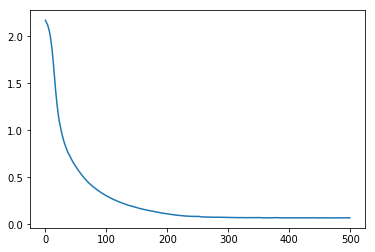

In [314]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])

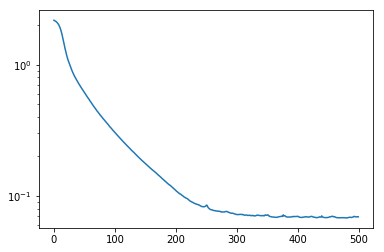

In [315]:
plt.yscale('log')
plt.plot(history.history['loss'])

## Next step is to reduce the embedding to 2 for visualization making it the bottle neck

In [316]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Embedding, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, Model

embedding_dim = 2
n_players = len(x)
n_features = Y_std_pca.shape[1]

dropout = .4
recurrent_dropout = .4

model = Sequential()
model.add(Embedding(name='embedding',
                    input_dim=n_players, 
                    output_dim=embedding_dim, 
                    input_length=1))

model.add(Dense(units=5, name='hidden1', activation='tanh'))
# model.add(Dense(units=500, name='hidden2', activation='tanh'))

# model.add(BatchNormalization())
# model.add(Dropout(dropout))

model.add(Dense(units=n_features, name='output', activation='linear'))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 2)              52        
_________________________________________________________________
hidden1 (Dense)              (None, 1, 5)              15        
_________________________________________________________________
output (Dense)               (None, 1, 14)             84        
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [317]:
%%time

EPOCHS=500
BATCH_SIZE=1

history = model.fit(x, Y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

CPU times: user 50.1 s, sys: 5.16 s, total: 55.3 s
Wall time: 38.6 s


In [318]:
loss = model.evaluate(x, Y, batch_size=BATCH_SIZE)
loss

26/26 [==============================] - 0s 3ms/sample - loss: 0.5694


0.5693843204241532

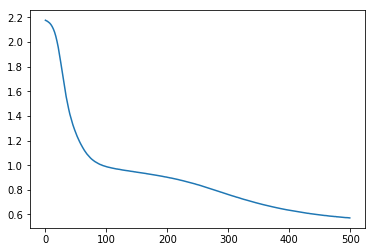

In [319]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])

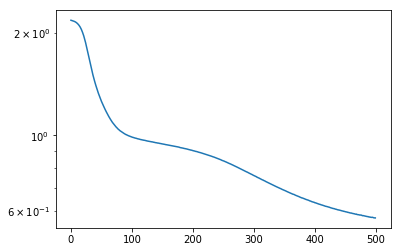

In [320]:
plt.yscale('log')
plt.plot(history.history['loss'])

In [321]:
model.predict([0])

array([[[-3.4841423 ,  2.181376  ,  2.820847  , -0.80914074,
          0.16753343, -0.13296606, -0.29002404,  0.05893639,
         -0.0581853 , -0.37613693, -0.01312646,  0.04030755,
         -0.12039252, -0.04123456]]], dtype=float32)

In [322]:
Y[0]

array([[-3.29862219,  1.92550053,  2.97745647, -1.65706016,  1.18469778,
        -0.22982443,  0.59047424, -0.21617609,  0.21856442, -1.05038903,
        -0.5053879 ,  0.20262308, -0.64611977,  0.49940276]])

In [0]:
embedding_layer = model.get_layer('embedding')
embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
embeddings_2d = embedding_model.predict(x).reshape(-1, 2)

In [324]:
embeddings_2d

array([[-1.2947828 ,  1.8385831 ],
       [-0.64112836,  0.7314111 ],
       [ 1.087652  ,  0.7786306 ],
       [ 0.00617731, -0.03498497],
       [-0.21342939, -0.0849779 ],
       [-0.27432767, -0.04473805],
       [-1.7648604 ,  1.6917895 ],
       [-0.85895944,  0.03856448],
       [-0.4349943 , -0.51885265],
       [-1.5750794 ,  1.8564216 ],
       [-0.43365765, -1.0393355 ],
       [-0.22543137, -0.35605222],
       [-0.18626107, -1.0237259 ],
       [-0.54710317, -1.0490768 ],
       [-0.98167104,  0.09242693],
       [-1.5829644 , -1.1608953 ],
       [-0.84138864, -1.2215123 ],
       [ 0.30564028, -1.3548814 ],
       [ 0.08548702, -1.5154454 ],
       [ 0.49092472, -0.8732984 ],
       [-0.8738963 , -1.3677431 ],
       [ 1.4756281 , -0.74862677],
       [ 1.4319991 , -0.44064802],
       [ 1.4007266 , -0.72312224],
       [ 1.3659549 , -0.6882697 ],
       [ 1.2877356 , -0.02703339]], dtype=float32)

In [0]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

colors = le.fit_transform(df['Position'])

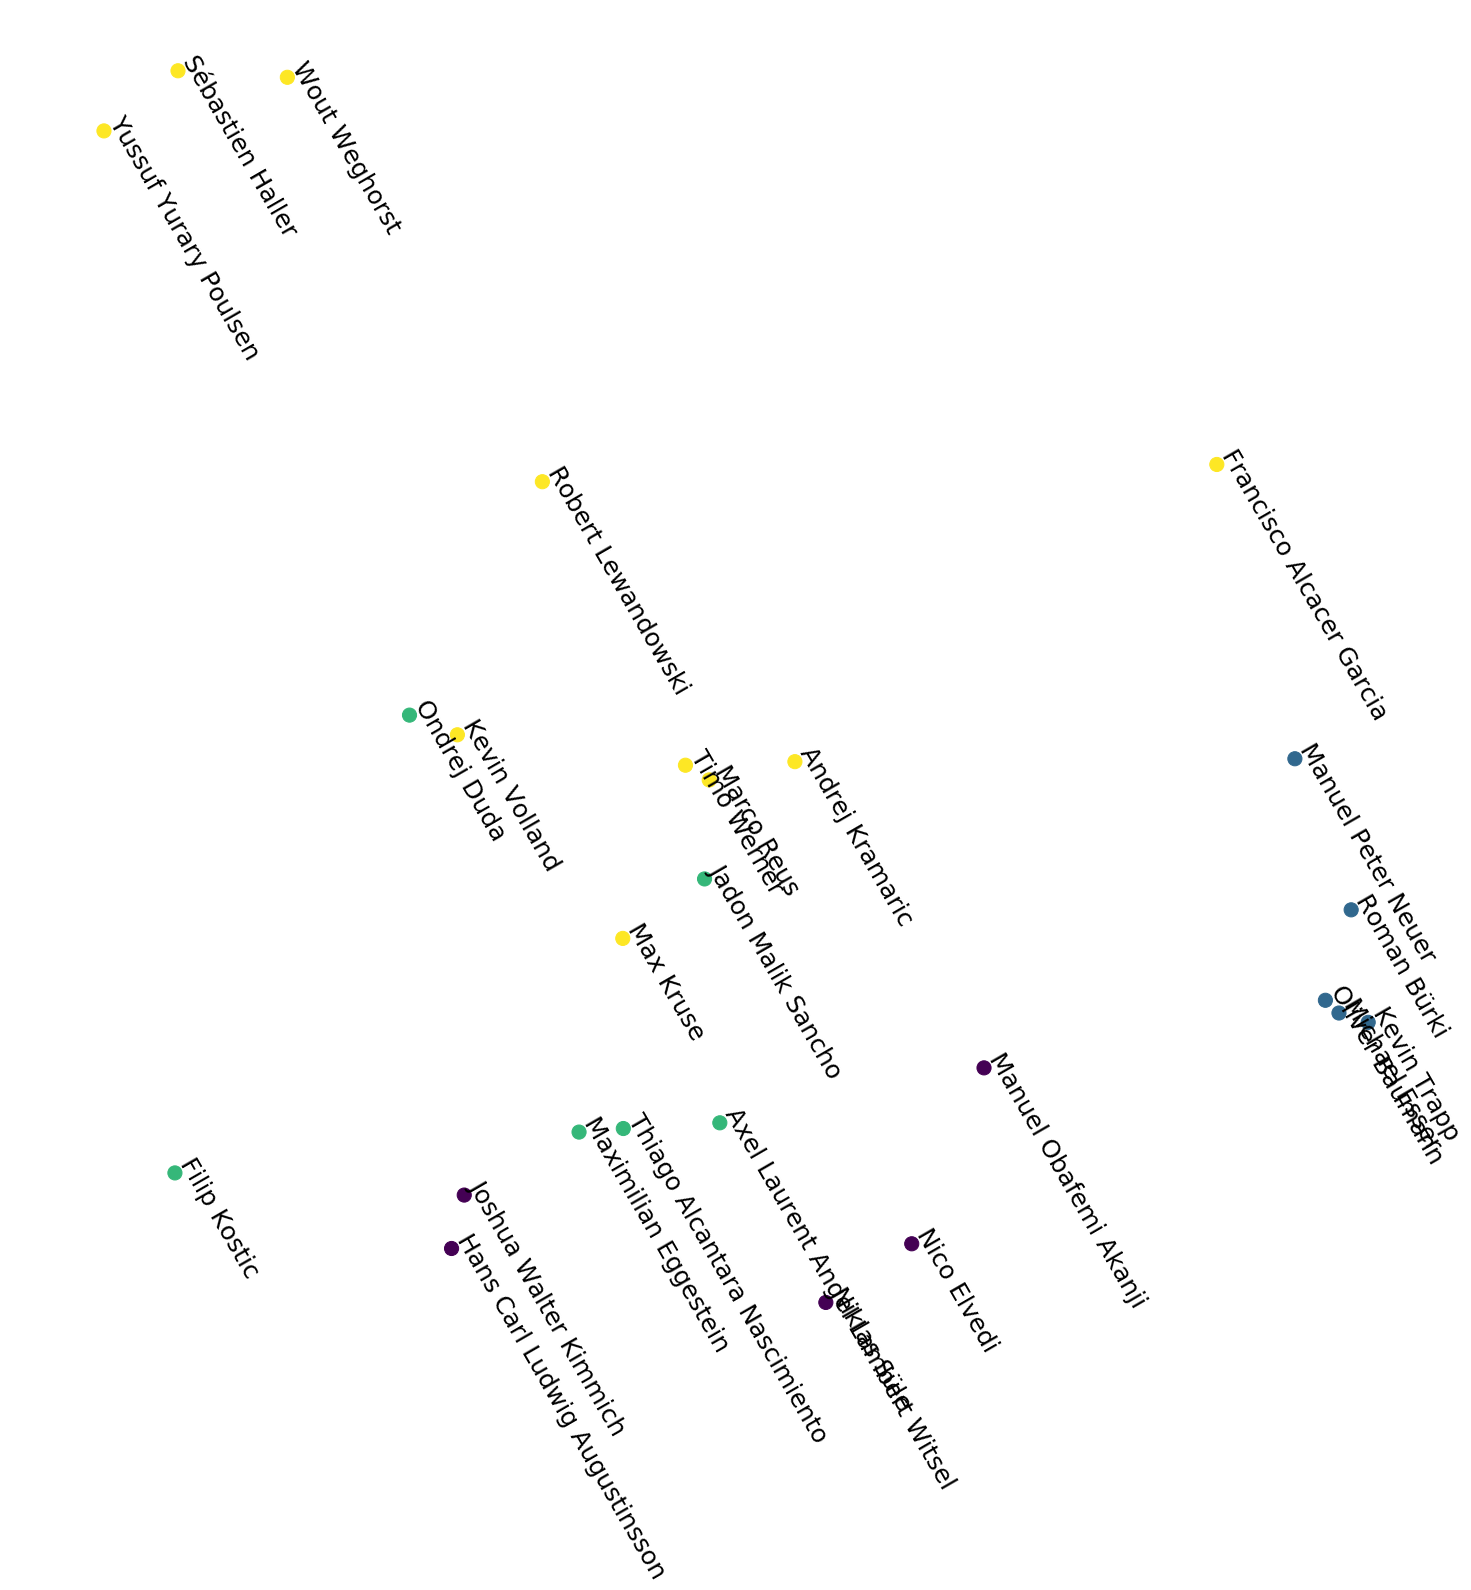

In [326]:
# for printing only
plt.figure(figsize=(25,25))
# plt.figure(dpi=600)
# plt.figure(dpi=300)

plt.axis('off')

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, s=200)
for name, x_pos, y_pos in zip(names, embeddings_2d[:, 0], embeddings_2d[:, 1]):
#   print(name, (x_pos, y_pos))
  plt.annotate(name, (x_pos, y_pos),  rotation=-60, size=25)

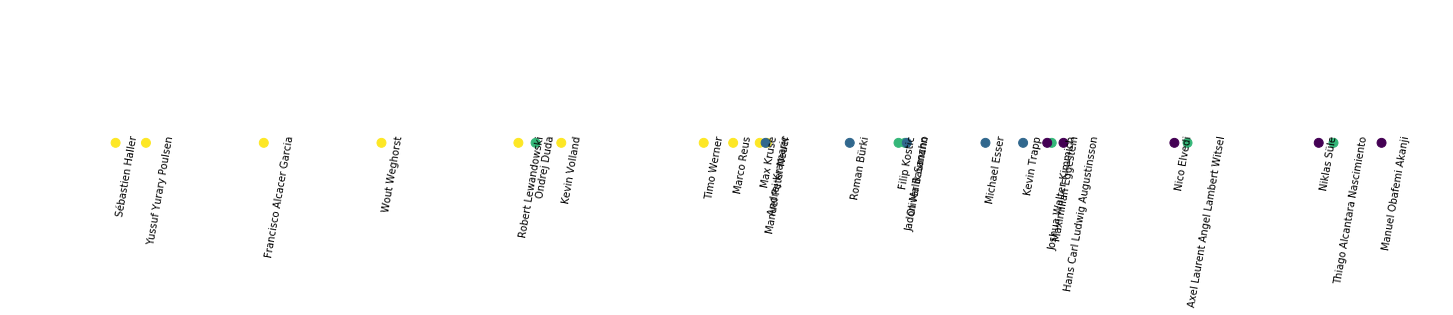

In [0]:
import numpy as np

embeddings_1d = embeddings_2d[:, 0]

# for printing only
plt.figure(figsize=(25,5))
# plt.figure(dpi=300)

plt.axis('off')

plt.scatter(embeddings_1d, np.zeros(len(embeddings_1d)), c=colors, s=80)
for name, x_pos in zip(names, embeddings_1d):
  plt.annotate(name, (x_pos, 0), rotation=80)

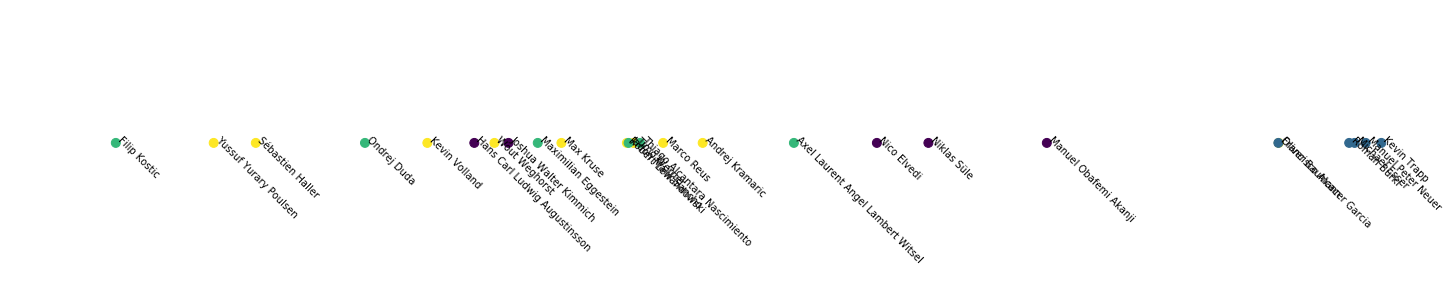

In [0]:
import numpy as np

embeddings_1d = embeddings_2d[:, 1]

# for printing only
plt.figure(figsize=(25,5))
# plt.figure(dpi=300)

plt.axis('off')

plt.scatter(embeddings_1d, np.zeros(len(embeddings_1d)), c=colors, s=80)
for name, x_pos in zip(names, embeddings_1d):
  plt.annotate(name, (x_pos, 0), rotation=-45)

## One dimension Embedding

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Embedding, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, Model

embedding_dim = 1
n_players = len(x)
n_features = Y_std_pca.shape[1]

dropout = .7

model = Sequential()
model.add(Embedding(name='embedding',
                    input_dim=n_players, 
                    output_dim=embedding_dim, 
                    input_length=1))

model.add(Dense(units=5, name='hidden1', activation='tanh'))
# model.add(Dense(units=500, name='hidden2', activation='tanh'))

# model.add(BatchNormalization())
# model.add(Dropout(dropout))

model.add(Dense(units=n_features, name='output', activation='linear'))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 1)              26        
_________________________________________________________________
hidden1 (Dense)              (None, 1, 5)              10        
_________________________________________________________________
output (Dense)               (None, 1, 10)             60        
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________


In [0]:
%%time

EPOCHS=1000
BATCH_SIZE=1

history = model.fit(x, Y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

CPU times: user 1min 35s, sys: 10.1 s, total: 1min 45s
Wall time: 1min 11s


In [0]:
loss = model.evaluate(x, Y, batch_size=BATCH_SIZE)
loss

26/26 [==============================] - 0s 2ms/sample - loss: 0.8966


0.8965825434201039

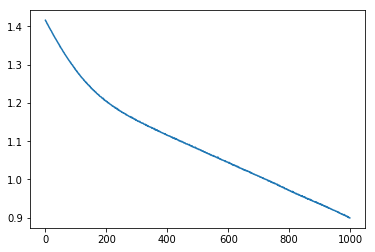

In [0]:
# plt.yscale('log')
plt.plot(history.history['loss'])

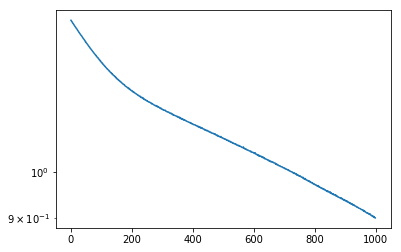

In [0]:
plt.yscale('log')
plt.plot(history.history['loss'])

In [0]:
embedding_layer = model.get_layer('embedding')
embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
embeddings_1d = embedding_model.predict(x).reshape(-1)

<Figure size 1800x1200 with 0 Axes>

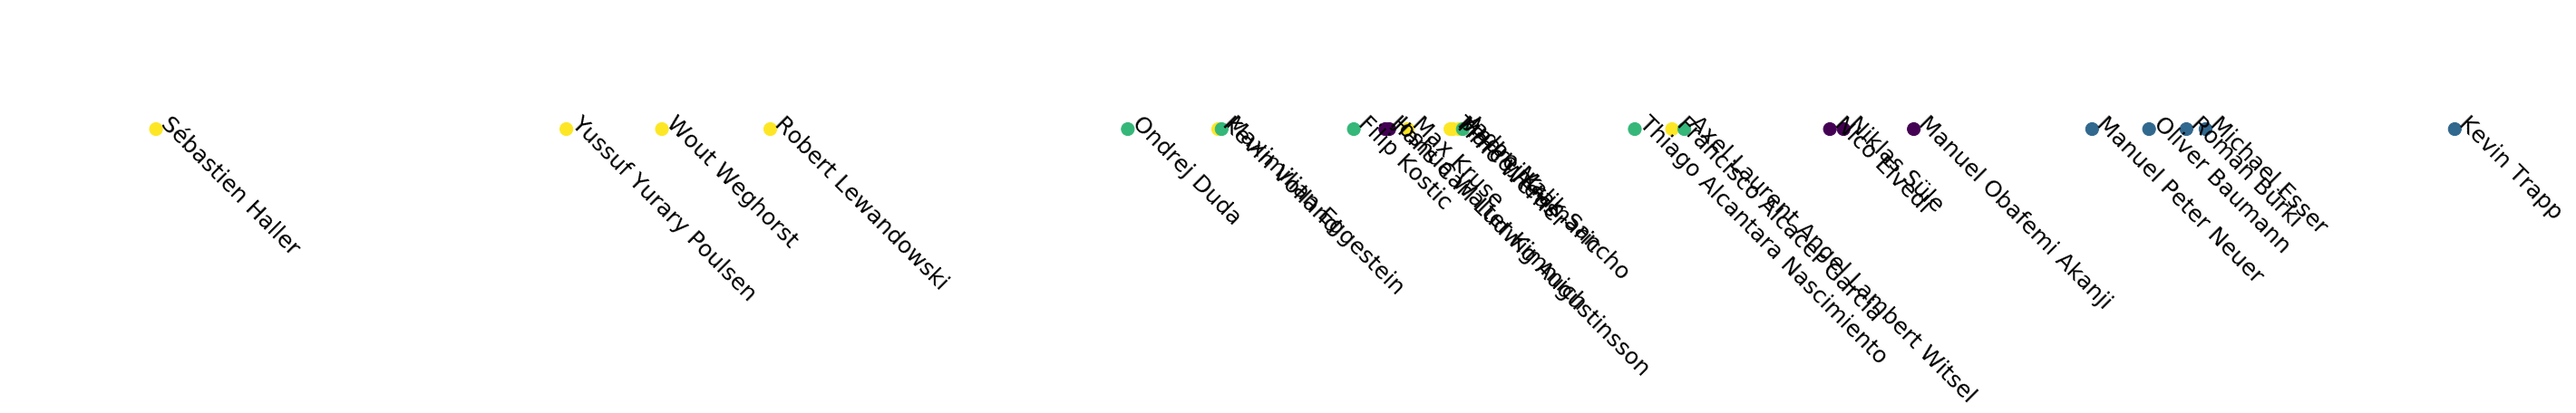

In [0]:
# for printing only
plt.figure(dpi=300)
plt.figure(figsize=(50,5))

plt.axis('off')

plt.scatter(embeddings_1d, np.zeros(len(embeddings_1d)), c=colors, s=200)
for name, x_pos in zip(names, embeddings_1d):
  plt.annotate(name, (x_pos, 0), rotation=-45, size=25)